In [1]:
%pylab inline
import os
import mrcfile
import numpy as np
import cupy as cp
import pandas as pd
from tqdm.notebook import tqdm

sys.path.append('/SIFT_gs/')
from SIFT_gs.FIBSEM_SIFT_gs import *

Populating the interactive namespace from numpy and matplotlib


C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depreca

Open CV version:  4.6.0


In [2]:
def correlation_coefficient(frame1, frame2):
    product = np.mean((frame1 - frame1.mean()) * (frame2 - frame2.mean()))
    stds = frame1.std() * frame2.std()
    if stds == 0:
        return 0
    else:
        product /= stds
        return product

def read_transformation_matrix_from_xf_file(xf_filename):
    '''
    Reads transformation matrix created by FiJi-based workflow from *.xf file. ©G.Shtengel 10/2022 gleb.shtengel@gmail.com
    
    Parameters:
    xf_filename : str
        Full path to *.xf file containing the transformation matrix data

    Returns:
    transformation_matrix : array
    '''
    npdt_recalled = pd.read_csv(fn, sep = '  ', header = None)
    tr = npdt_recalled.to_numpy()
    transformation_matrix = np.zeros((len(tr), 3, 3))
    transformation_matrix[:, 0, 0:2] = tr[:,0:2]
    transformation_matrix[:, 0, 2] = tr[:,6]
    transformation_matrix[:, 1, 0:2] = tr[:,2:4]
    transformation_matrix[:, 1, 2] = tr[:,9]
    transformation_matrix[:, 2, 2] = np.ones((len(tr)))   
    return transformation_matrix

def analyze_transformation_matrix(transformation_matrix, xf_filename):
    '''
    Analyzes the transformation matrix created by FiJi-based workflow. ©G.Shtengel 10/2022 gleb.shtengel@gmail.com
    
    Parameters:
    transformation_matrix : array
        Transformation matrix (read by read_transformation_matrix_from_xf_file above).
    xf_filename : str
        Full path to *.xf file containing the transformation matrix data

    Returns:
    tr_matr_cum : array
    Cumulative transformation matrix
    '''
    Xshift_orig = transformation_matrix[:, 0, 2]
    Yshift_orig = transformation_matrix[:, 1, 2]
    Xscale_orig = transformation_matrix[:, 0, 0]
    Yscale_orig = transformation_matrix[:, 1, 1]
    tr_matr_cum = transformation_matrix.copy()

    prev_mt = np.eye(3,3)
    for j, cur_mt in enumerate(tqdm(transformation_matrix, desc='Calculating Cummilative Transformation Matrix')):
        if any(np.isnan(cur_mt)):
            print('Frame: {:d} has ill-defined transformation matrix, will use identity transformation instead:'.format(j))
            print(cur_mt)
        else:
            prev_mt = np.matmul(cur_mt, prev_mt)
        tr_matr_cum[j] = prev_mt
    # Now insert identity matrix for the zero frame which does not need to be trasformed
    tr_matr_cum_orig = tr_matr_cum.copy()

    s00_cum_orig = tr_matr_cum[:, 0, 0].copy()
    s11_cum_orig = tr_matr_cum[:, 1, 1].copy()
    s01_cum_orig = tr_matr_cum[:, 0, 1].copy()
    s10_cum_orig = tr_matr_cum[:, 1, 0].copy()
    
    Xshift_cum_orig = tr_matr_cum_orig[:, 0, 2]
    Yshift_cum_orig = tr_matr_cum_orig[:, 1, 2]


    #print('Recalculating Shifts')
    s00_cum_orig = tr_matr_cum[:, 0, 0]
    s11_cum_orig = tr_matr_cum[:, 1, 1]
    fr = np.arange(0, len(s00_cum_orig), dtype=float)
    s00_slp = -1.0 * (np.sum(fr)-np.dot(s00_cum_orig,fr))/np.dot(fr,fr) # find the slope of a linear fit with fiorced first scale=1
    s00_fit = 1.0 + s00_slp * fr
    s00_cum_new = s00_cum_orig + 1.0 - s00_fit
    s11_slp = -1.0 * (np.sum(fr)-np.dot(s11_cum_orig,fr))/np.dot(fr,fr) # find the slope of a linear fit with fiorced first scale=1
    s11_fit = 1.0 + s11_slp * fr
    s11_cum_new = s11_cum_orig + 1.0 - s11_fit
    
    s01_slp = np.dot(s01_cum_orig,fr)/np.dot(fr,fr) # find the slope of a linear fit with forced first scale=1
    s01_fit = s01_slp * fr
    s01_cum_new = s01_cum_orig - s01_fit
    s10_slp = np.dot(s10_cum_orig,fr)/np.dot(fr,fr) # find the slope of a linear fit with forced first scale=1
    s10_fit = s10_slp * fr
    s10_cum_new = s10_cum_orig - s10_fit

    Xshift_cum = tr_matr_cum[:, 0, 2]
    Yshift_cum = tr_matr_cum[:, 1, 2]

    subtract_linear_fit=True

    # Subtract linear trend from offsets
    if subtract_linear_fit:
        fr = np.arange(0, len(Xshift_cum) )
        pX = np.polyfit(fr, Xshift_cum, 1)
        Xfit = np.polyval(pX, fr)
        pY = np.polyfit(fr, Yshift_cum, 1)
        Yfit = np.polyval(pY, fr)
        Xshift_residual = Xshift_cum - Xfit
        Yshift_residual = Yshift_cum - Yfit
    else:
        Xshift_residual = Xshift_cum.copy()
        Yshift_residual = Yshift_cum.copy()

    # define new cum. transformation matrix where the offests may have linear slopes subtracted
    tr_matr_cum_residual = tr_matr_cum.copy()
    tr_matr_cum_residual[:, 0, 2] = Xshift_residual
    tr_matr_cum_residual[:, 1, 2] = Yshift_residual
    tr_matr_cum_residual[:, 0, 0] = s00_cum_new
    tr_matr_cum_residual[:, 1, 1] = s11_cum_new
    tr_matr_cum_residual[:, 0, 1] = s01_cum_new
    tr_matr_cum_residual[:, 1, 0] = s10_cum_new

    fs = 12
    fig5, axs5 = subplots(3,3, figsize=(18, 12), sharex=True)
    fig5.subplots_adjust(left=0.15, bottom=0.08, right=0.99, top=0.94)

    # plot scales
    axs5[0, 0].plot(Xscale_orig, 'r', label = 'Sxx fr.-to-fr.')
    axs5[0, 0].plot(Yscale_orig, 'b', label = 'Syy fr.-to-fr.')
    axs5[0, 0].set_title('Frame-to-Frame Scale Change', fontsize = fs + 1)
    axs5[1, 0].plot(tr_matr_cum_orig[:, 0, 0], 'r', linestyle='dotted', label = 'Sxx cum.')
    axs5[1, 0].plot(tr_matr_cum_orig[:, 1, 1], 'b', linestyle='dotted', label = 'Syy cum.')
    axs5[1, 0].plot(s00_fit, 'r', label = 'Sxx cum. - lin. fit')
    axs5[1, 0].plot(s11_fit, 'b', label = 'Syy cum. - lin. fit')
    axs5[1, 0].set_title('Cumulative Scale', fontsize = fs + 1)
    axs5[2, 0].plot(tr_matr_cum_residual[:, 0, 0], 'r', label = 'Sxx cum. - residual')
    axs5[2, 0].plot(tr_matr_cum_residual[:, 1, 1], 'b', label = 'Syy cum. - residual')
    axs5[2, 0].set_title('Residual Cumulative Scale', fontsize = fs + 1)
    axs5[2, 0].set_xlabel('Frame', fontsize = fs + 1)
    
    # plot shears
    axs5[0, 1].plot(transformation_matrix[:, 0, 1], 'r', label = 'Sxy fr.-to-fr.')
    axs5[0, 1].plot(transformation_matrix[:, 1, 0], 'b', label = 'Syx fr.-to-fr.')
    axs5[0, 1].set_title('Frame-to-Frame Shear', fontsize = fs + 1)
    axs5[1, 1].plot(tr_matr_cum_orig[:, 0, 1], 'r', linestyle='dotted', label = 'Sxy cum.')
    axs5[1, 1].plot(tr_matr_cum_orig[:, 1, 0], 'b', linestyle='dotted', label = 'Syx cum.')
    axs5[1, 1].plot(s01_fit, 'r', label = 'Sxy cum. - lin. fit')
    axs5[1, 1].plot(s10_fit, 'b', label = 'Syx cum. - lin. fit')
    axs5[1, 1].set_title('Cumulative Shear', fontsize = fs + 1)
    axs5[2, 1].plot(tr_matr_cum_residual[:, 0, 1], 'r', label = 'Sxy cum. - residual')
    axs5[2, 1].plot(tr_matr_cum_residual[:, 1, 0], 'b', label = 'Syx cum. - residual')
    axs5[2, 1].set_title('Residual Cumulative Shear', fontsize = fs + 1)
    axs5[2, 1].set_xlabel('Frame', fontsize = fs + 1)

    # plot shifts
    axs5[0, 2].plot(Xshift_orig, 'r', label = 'Tx fr.-to-fr.')
    axs5[0, 2].plot(Yshift_orig, 'b', label = 'Ty fr.-to-fr.')
    axs5[0, 2].set_title('Frame-to-Frame Shift', fontsize = fs + 1)
    axs5[1, 2].plot(Xshift_cum, 'r', linestyle='dotted', label = 'Tx cum.')
    axs5[1, 2].plot(Xfit, 'r', label = 'Tx cum. - lin. fit')
    axs5[1, 2].plot(Yshift_cum, 'b', linestyle='dotted', label = 'Ty cum.')
    axs5[1, 2].plot(Yfit, 'b', label = 'Ty cum. - lin. fit')
    axs5[1, 2].set_title('Cumulative Shift', fontsize = fs + 1)
    axs5[2, 2].plot(tr_matr_cum_residual[:, 0, 2], 'r', label = 'Tx cum. - residual')
    axs5[2, 2].plot(tr_matr_cum_residual[:, 1, 2], 'b', label = 'Ty cum. - residual')
    axs5[2, 2].set_title('Residual Cumulative Shift', fontsize = fs + 1)
    axs5[2, 2].set_xlabel('Frame', fontsize = fs + 1)

    for ax in axs5.ravel():
        ax.grid(True)
        ax.legend()
    fig5.suptitle(xf_filename, fontsize = fs + 2)
    fig5.savefig(xf_filename +'_Transform_Summary.png', dpi=300)
    return tr_matr_cum

C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


Calculating Cummilative Transformation Matrix:   0%|          | 0/3450 [00:00<?, ?it/s]

Frame: 277 has ill-defined transformation matrix, will use identity transformation instead:
[[ 1.0000065e+00 -4.1020000e-04 -1.9250000e+00]
 [-4.4300000e-05  9.9936830e-01            nan]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]


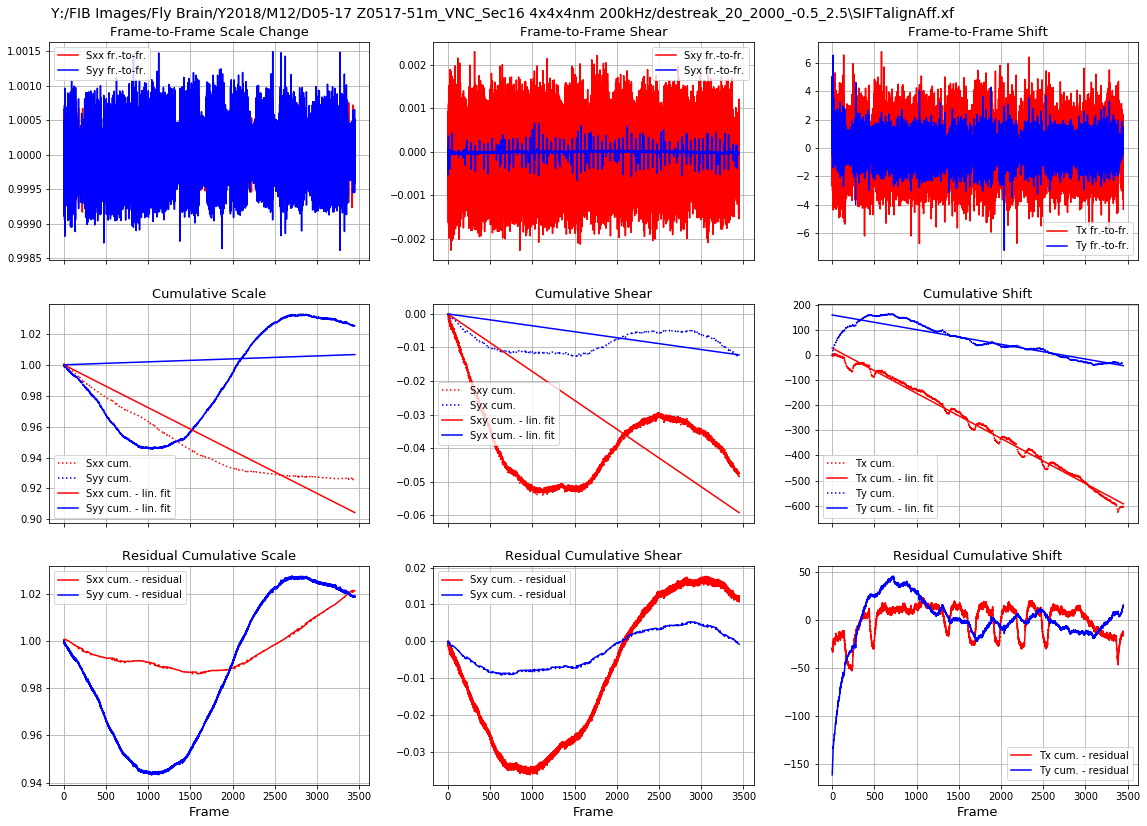

In [3]:
data_dir = 'Z:/FIB-SEM SIFT align code/Test data'
data_dir = 'Z:/FIB-SEM SIFT align code/Test data 2 from J10'
data_dir = 'X:/instruments/fib-sem/Y2021/Shirish/WT1/SIFT'
transf_file = 'SIFTalignAffA.xf'
fn = os.path.join(data_dir, transf_file)

data_dir1 = 'Y:/FIB Images/Fly Brain/Y2018/M12/D05-17 Z0517-51m_VNC_Sec16 4x4x4nm 200kHz/destreak_20_2000_-0.5_2.5'
FiJiSIFT_Aff_transform_matr = os.path.join(data_dir1, 'SIFTalignAff.xf')
fn = FiJiSIFT_Aff_transform_matr

transformation_matrix_aff = read_transformation_matrix_from_xf_file(fn)
tt = analyze_transformation_matrix(transformation_matrix_aff, fn)

In [4]:
data_dir = 'Y:/FIB Images/Fly Brain/Y2018/M12/D05-17 Z0517-51m_VNC_Sec16 4x4x4nm 200kHz'

ftype = 0 # 0 for Shan's .dat files, 1 for tif files

use_DASK = True

threshold_min = 1e-3    # These are used to determine Min and Max data boundaries for I8 conversion
threshold_max = 1e-3                            
sliding_minmax = True   # If True, Global Min and Max for I8 conversion the entire data set is used. If False, Min and Max are allowed to vary slowly.
nbins = 256             # Number of histogram bins for determining Min and Max above

BFMatcher = False       # If True, the BF Matcher is used for keypont matching
                        # otherwise FLANN Matcher (faster, preferable) is used.

save_matches = True     # If True, matches will be saved into individual files

kp_max_num = 100000      # max number of key-points to be matched. Key-points in every frame are indexed (in descending order)
                        # by the strength of the response. Only kp_max_num is kept for further processing.
                        # Set this value to -1 if you want to keep ALL keypoints (may take forever to process!)

# Uncomment one from the below choices:
#TransformType = ShiftTransform                #  only x-shift and y-shift
#TransformType = XScaleShiftTransform          #  x-scale, x-shift, y-shift
#TransformType = ScaleShiftTransform           #  x-scale, y-scale, x-shift, y-shift
#TransformType = AffineTransform               #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
TransformType = RegularizedAffineTransform     #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
                                                # with regularization on deviation from ShiftTransform
if TransformType == RegularizedAffineTransform:
    l2_param = 1e-5                                  # regularization strength (shrinkage parameter)
    l2_matrix = np.eye(6)*l2_param                   # initially set equal shrinkage on all coefficients
    l2_matrix[2,2]=0                                 # turn OFF the regularization on shifts
    l2_matrix[5,5]=0                                 # turn OFF the regularization on shifts
    targ_vector = np.array([1, 0, 0, 0, 1, 0])       # target transformation is shift only: Sxx=Syy=1, Sxy=Syx=0
    suffix = 'l2_{:.0e}'.format(l2_matrix[0,0])
else:
    l2_matrix= None
    targ_vector = None
    suffix = 'bilin'                  # optonal characters that will be added to the end of the filename (before the extension)

SIFT_nfeatures = 0     # SIFT libary default is 0. The number of best features to retain.
                                # The features are ranked by their scores (measured in SIFT algorithm as the local contrast)
    
SIFT_nOctaveLayers = 3          # SIFT libary default  is 3. The number of layers in each octave.
                                # 3 is the value used in D. Lowe paper. The number of octaves is computed automatically from the image resolution.

SIFT_contrastThreshold = 0.025   # SIFT libary default  is 0.04. The contrast threshold used to filter out weak features in semi-uniform (low-contrast) regions.
                                # The larger the threshold, the less features are produced by the detector.
                                # The contrast threshold will be divided by nOctaveLayers when the filtering is applied.
                                # When nOctaveLayers is set to default and if you want to use the value used in
                                # D. Lowe paper (0.03), set this argument to 0.09.
                                
SIFT_edgeThreshold = 10         # SIFT libary default  is 10. The threshold used to filter out edge-like features.
                                # Note that the its meaning is different from the contrastThreshold,
                                # i.e. the larger the edgeThreshold, the less features are filtered out
                                # (more features are retained).

SIFT_sigma = 1.6                # SIFT library default is 1.6. 	The sigma of the Gaussian applied to the input image at the octave #0.
                                # If your image is captured with a weak camera with soft lenses, you might want to reduce the number.
    
Lowe_Ratio_Threshold = 0.7

solver = 'RANSAC'       # String indicating which solver is to be used.'RANSAC' will use RANSAC (Random Sample Consensus) algorithm.
                        # 'LinReg' will use Linear Regression with iterative "Throwing out the Worst Residual" Heuristic

drmax = 1.5              # dimensions - pixels.
                         #  - in the case of 'RANSAC' - Maximum distance for a data point to be classified as an inlier.
                         #  - in the case of 'LinReg' - outlier threshold for iterative regression:
                         # For each matched pair of keypoins the error is calculated as err[j] = dst_pts[j] - A*src_pts[j]
                         # The iterative procedure throws away the matched keypoint pair with worst error on every iteration
                         # until the worst error falls below drmax or the max number of iterations is reached.

max_iter = 1000     # max number of iterations in the iterative procedure above

save_data_as_tiff = False    # Convert and Save the InLens.tif data

save_res_png = True        # Save PNG images of the intemediate processing statistics and final registration quality check.

save_asI8 = False            # If true, the data will be converted to I8 using global MIN and MAX values determined in the Step 1

preserve_scales = True       # If True, the transformation matrix will be adjusted using the settings defined by fit_params below
fit_params = ['SG', 501, 3]  # perform the above adjustment using  Savitzky-Golay (SG) filter with parameters
                             # window size 501, polynomial order 3
#fit_params = ['LF']         # another option is to use linear fit with forces start points Sxx and Syy = 1 and Sxy and Syx = 0
#fit_params = ['PF', 2]      # another option is to use polynomial fit (in this case of order 2)

subtract_linear_fit = [True, True]  # If True, the linear slopes along X- and Y- directions (respectively) will be subtracted from the cumulative shifts.
                                    # This is performed after the optimal frame-to-frame shifts are recalculated for preserve_scales = True 

pad_edges = True             # If True, the edges will be padded with the amount equal to max shift excursion in each direction

flipY = False                 # If True, the dataset will be flipped along Y-direction

zbin_factor =  1             # binning factor in z-direction (milling direction). Data will be binned when saving the final result. Default is 1.

int_order = 1                #     The order of interpolation. The order has to be in the range 0-5:
                             #    - 0: Nearest-neighbor
                             #    - 1: Bi-linear (default)
                             #    - 2: Bi-quadratic
                             #    - 3: Bi-cubic
                             #    - 4: Bi-quartic
                             #    - 5: Bi-quintic
#suffix = suffix + '_r1'
#********************************************************************************************************
# DO NOT MODIFY THE CODE BELOW!
#********************************************************************************************************

if ftype == 0:
    fls = sorted(glob.glob(os.path.join(data_dir,'*.dat')))
    if len(fls) < 1:
        fls = sorted(glob.glob(os.path.join(data_dir,'*/*.dat')))
if ftype == 1:
    fls = sorted(glob.glob(os.path.join(data_dir,'*.tif')))
    if len(fls) < 1:
        fls = sorted(glob.glob(os.path.join(data_dir,'*/*.tif')))
        
nfrs = len(fls)
#print('Total Number of frames to process: ', nfrs)                      

if fit_params[1] > nfrs//2*2-1:  # if smoothing aperture (Sov-Gol) is larger than number of frames, reduce the aperture
    fit_params[1] = nfrs//2*2-1

fnm0 = (os.path.join(data_dir,fls[0]))
frame0 = FIBSEM_frame(fnm0, ftype=ftype)
Sample_ID = frame0.Sample_ID.strip('\x00')
EightBit = frame0.EightBit

SIFT_kwargs = {'fnm_reg' : 'SIFTalignAff_orig.mrc',
    'ftype' : ftype,
    'data_dir' : 'Y:/FIB Images/Fly Brain/Y2018/M12/D05-17 Z0517-51m_VNC_Sec16 4x4x4nm 200kHz/destreak_20_2000_-0.5_2.5',
    'Sample_ID' : Sample_ID,
    'EightBit' : EightBit,
    'use_DASK' : use_DASK,
    'threshold_min' : threshold_min, 
    'threshold_max' : threshold_max,
    'sliding_minmax' : sliding_minmax,
    'nbins' : nbins,
    'TransformType' : TransformType,
    'SIFT_nfeatures' : SIFT_nfeatures,
    'SIFT_nOctaveLayers' : SIFT_nOctaveLayers,
    'SIFT_contrastThreshold' : SIFT_contrastThreshold,
    'SIFT_edgeThreshold' : SIFT_edgeThreshold,
    'SIFT_sigma' : SIFT_sigma,
    'Lowe_Ratio_Threshold' : Lowe_Ratio_Threshold,
    'l2_matrix' : l2_matrix,
    'targ_vector': targ_vector, 
    'solver' : solver,
    'drmax' : drmax,
    'max_iter' : max_iter,
    'BFMatcher' : BFMatcher,
    'save_matches' : save_matches,
    'kp_max_num' : kp_max_num,
    'save_res_png' : save_res_png,
    'save_data_as_tiff' : save_data_as_tiff,
    'save_asI8' : save_asI8,
    'preserve_scales' : preserve_scales,
    'fit_params' : fit_params,
    'subtract_linear_fit' : subtract_linear_fit,
    'pad_edges' : pad_edges,
    'flipY' : flipY,
    'zbin_factor' : zbin_factor,
    'int_order' : int_order,
    'suffix' : suffix}


In [6]:
data_dir1 = 'Y:/FIB Images/Fly Brain/Y2018/M12/D05-17 Z0517-51m_VNC_Sec16 4x4x4nm 200kHz/destreak_20_2000_-0.5_2.5'
FiJiSIFT_Aff_transform_matr = os.path.join(data_dir1, 'SIFTalignAff.xf')
transformation_matrix_aff = read_transformation_matrix_from_xf_file(FiJiSIFT_Aff_transform_matr)
nfrs = len(transformation_matrix_aff)
fnms_matches = np.zeros(nfrs)+1
npts = np.zeros(nfrs)+1
error_abs_mean = np.zeros(nfrs)+1


C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
def process_transf_matrix(transformation_matrix, fnms_matches, npts, error_abs_mean, **kwargs):
    data_dir = kwargs.get("data_dir", '')
    fnm_reg = kwargs.get("fnm_reg", 'Registration_file.mrc')
    TransformType = kwargs.get("TransformType", RegularizedAffineTransform)
    Sample_ID = kwargs.get("Sample_ID", '')

    l2_param_default = 1e-5                                  # regularization strength (shrinkage parameter)
    l2_matrix_default = np.eye(6)*l2_param_default                   # initially set equal shrinkage on all coefficients
    l2_matrix_default[2,2] = 0                                 # turn OFF the regularization on shifts
    l2_matrix_default[5,5] = 0                                 # turn OFF the regularization on shifts
    l2_matrix = kwargs.get("l2_matrix", l2_matrix_default)
    targ_vector = kwargs.get("targ_vector", np.array([1, 0, 0, 0, 1, 0]))   # target transformation is shift only: Sxx=Syy=1, Sxy=Syx=0
    solver = kwargs.get("solver", 'RANSAC')
    drmax = kwargs.get("drmax", 2.0)
    max_iter = kwargs.get("max_iter", 1000)
    BFMatcher = kwargs.get("BFMatcher", False)           # If True, the BF Matcher is used for keypont matching, otherwise FLANN will be used
    save_matches = kwargs.get("save_matches", True)      # If True, matches will be saved into individual files
    kp_max_num = kwargs.get("kp_max_num", -1)
    save_res_png  = kwargs.get("save_res_png", True)

    preserve_scales =  kwargs.get("preserve_scales", True)  # If True, the transformation matrix will be adjusted using teh settings defined by fit_params below
    fit_params =  kwargs.get("fit_params", False)           # perform the above adjustment using  Savitzky-Golay (SG) fith with parameters
                                                            # window size 701, polynomial order 3
    subtract_linear_fit =  kwargs.get("subtract_linear_fit", [True, True])   # The linear slopes along X- and Y- directions (respectively) will be subtracted from the cumulative shifts.
    #print("subtract_linear_fit:", subtract_linear_fit)
    pad_edges =  kwargs.get("pad_edges", True)

    tr_matr_cum = transformation_matrix.copy()   
    prev_mt = np.eye(3,3)
    for j, cur_mt in enumerate(tqdm(transformation_matrix, desc='Calculating Cummilative Transformation Matrix')):
        if any(np.isnan(cur_mt)):
            print('Frame: {:d} has ill-defined transformation matrix, will use identity transformation instead:'.format(j))
            print(cur_mt)
        else:
            prev_mt = np.matmul(cur_mt, prev_mt)
        tr_matr_cum[j] = prev_mt
    # Now insert identity matrix for the zero frame which does not need to be trasformed

    tr_matr_cum = np.insert(tr_matr_cum, 0, np.eye(3,3), axis=0)  
    
    fr = np.arange(0, len(tr_matr_cum), dtype=np.double)
    s00_cum_orig = tr_matr_cum[:, 0, 0].astype(np.double)
    s01_cum_orig = tr_matr_cum[:, 0, 1].astype(np.double)
    s10_cum_orig = tr_matr_cum[:, 1, 0].astype(np.double)
    s11_cum_orig = tr_matr_cum[:, 1, 1].astype(np.double)
    Xshift_cum_orig = tr_matr_cum[:, 0, 2].astype(np.double)
    Yshift_cum_orig = tr_matr_cum[:, 1, 2].astype(np.double)

    if preserve_scales:  # in case of ScaleShift Transform WITH scale perservation
        #print('Recalculating the transformation matrix for preserved scales')
        tr_matr_cum, s_fits = find_fit(tr_matr_cum, fit_params)
        s00_fit, s01_fit, s10_fit, s11_fit = s_fits
        txs = np.zeros(len(tr_matr_cum), dtype=float)
        tys = np.zeros(len(tr_matr_cum), dtype=float)
        
        for j, fnm_matches in enumerate(tqdm(fnms_matches, desc='Recalculating the shifts for preserved scales: ')):
            try:
                src_pts, dst_pts = pickle.load(open(fnm_matches, 'rb'))

                txs[j+1] = np.mean(tr_matr_cum[j, 0, 0] * dst_pts[:, 0] + tr_matr_cum[j, 0, 1] * dst_pts[:, 1]
                                   - tr_matr_cum[j+1, 0, 0] * src_pts[:, 0] - tr_matr_cum[j+1, 0, 1] * src_pts[:, 1])
                tys[j+1] = np.mean(tr_matr_cum[j, 1, 1] * dst_pts[:, 1] + tr_matr_cum[j, 1, 0] * dst_pts[:, 0]
                                   - tr_matr_cum[j+1, 1, 1] * src_pts[:, 1] - tr_matr_cum[j+1, 1, 0] * src_pts[:, 0])
            except:
                txs[j+1] = 0.0
                tys[j+1] = 0.0
        txs_cum = np.cumsum(txs)
        tys_cum = np.cumsum(tys)
        tr_matr_cum[:, 0, 2] = txs_cum
        tr_matr_cum[:, 1, 2] = tys_cum

    Xshift_cum = tr_matr_cum[:, 0, 2].copy()
    Yshift_cum = tr_matr_cum[:, 1, 2].copy()

    # Subtract linear trends from offsets
    if subtract_linear_fit[0]:
        fr = np.arange(0, len(Xshift_cum))
        pX = np.polyfit(fr, Xshift_cum, 1)
        Xfit = np.polyval(pX, fr)
        Xshift_residual = Xshift_cum - Xfit
        #Xshift_residual0 = -np.polyval(pX, 0.0)
    else:
        Xshift_residual = Xshift_cum.copy()

    if subtract_linear_fit[1]:
        fr = np.arange(0, len(Yshift_cum))
        pY = np.polyfit(fr, Yshift_cum, 1)
        Yfit = np.polyval(pY, fr)
        Yshift_residual = Yshift_cum - Yfit
        #Yshift_residual0 = -np.polyval(pY, 0.0)
    else:
        Yshift_residual = Yshift_cum.copy()

    # define new cumulative transformation matrix where the offests may have linear slopes subtracted
    tr_matr_cum[:, 0, 2] = Xshift_residual
    tr_matr_cum[:, 1, 2] = Yshift_residual
    
    # save the data
    default_bin_file = os.path.join(data_dir, fnm_reg.replace('.mrc', '_transf_matrix.bin'))
    transf_matrix_bin_file = kwargs.get("dump_file", default_bin_file)
    transf_matrix_xlsx_file = default_bin_file.replace('.bin', '.xlsx')

    xlsx_writer = pd.ExcelWriter(transf_matrix_xlsx_file, engine='xlsxwriter')
    columns=['T00 (Sxx)', 'T01 (Sxy)', 'T02 (Tx)',  
                 'T10 (Syx)', 'T11 (Syy)', 'T12 (Ty)', 
                 'T20 (0.0)', 'T21 (0.0)', 'T22 (1.0)']
    tr_mx_dt = pd.DataFrame(transformation_matrix.reshape((len(transformation_matrix), 9)), columns = columns, index = None)
    tr_mx_dt.to_excel(xlsx_writer, index=None, sheet_name='Orig. Transformation Matrix')

    tr_mx_cum_dt = pd.DataFrame(tr_matr_cum.reshape((len(tr_matr_cum), 9)), columns = columns, index = None)
    tr_mx_cum_dt.to_excel(xlsx_writer, index=None, sheet_name='Cum. Transformation Matrix')

    columns_shifts=['s00_cum_orig', 's00_fit', 's11_cum_orig', 's11_fit', 's01_cum_orig', 's01_fit', 's10_cum_orig', 's10_fit', 'Xshift_cum_orig', 'Yshift_cum_orig', 'Xshift_cum', 'Yshift_cum', 'Xfit', 'Yfit']
    shifts_dt = pd.DataFrame(np.vstack((s00_cum_orig, s00_fit, s11_cum_orig, s11_fit, s01_cum_orig, s01_fit, s10_cum_orig, s10_fit, Xshift_cum_orig, Yshift_cum_orig, Xshift_cum, Yshift_cum, Xfit, Yfit)).T, columns = columns_shifts, index = None)
    shifts_dt.to_excel(xlsx_writer, index=None, sheet_name='Intermediate Results')
    
    columns_reg_stat = ['Npts', 'Mean Abs Error']
    reg_stat_dt = pd.DataFrame(np.vstack((npts, error_abs_mean)).T, columns = columns_reg_stat, index = None)
    reg_stat_dt.to_excel(xlsx_writer, index=None, sheet_name='Reg. Stat. Info')

    kwargs_info = pd.DataFrame([kwargs]).T   # prepare to be save in transposed format
    kwargs_info.to_excel(xlsx_writer, header=False, sheet_name='kwargs Info')

    xlsx_writer.save()

    DumpObject = [kwargs, npts, error_abs_mean,
              transformation_matrix, s00_cum_orig, s11_cum_orig, s00_fit, s11_fit,
              tr_matr_cum, s01_cum_orig, s10_cum_orig, s01_fit, s10_fit,
              Xshift_cum_orig, Yshift_cum_orig, Xshift_cum, Yshift_cum, Yshift_cum, Xfit, Yfit]
    with open(transf_matrix_bin_file,"wb") as f:
        pickle.dump(DumpObject, f)
    
    return tr_matr_cum, transf_matrix_xlsx_file


Calculating Cummilative Transformation Matrix:   0%|          | 0/3450 [00:00<?, ?it/s]

Frame: 277 has ill-defined transformation matrix, will use identity transformation instead:
[[ 1.0000065e+00 -4.1020000e-04 -1.9250000e+00]
 [-4.4300000e-05  9.9936830e-01            nan]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]


Recalculating the shifts for preserved scales:   0%|          | 0/3450 [00:00<?, ?it/s]

Loading SIFT kwarg Data
Loading Original Transformation Data
Loading Cumulative Transformation Data
Loading Intermediate Data
Loading Statistics


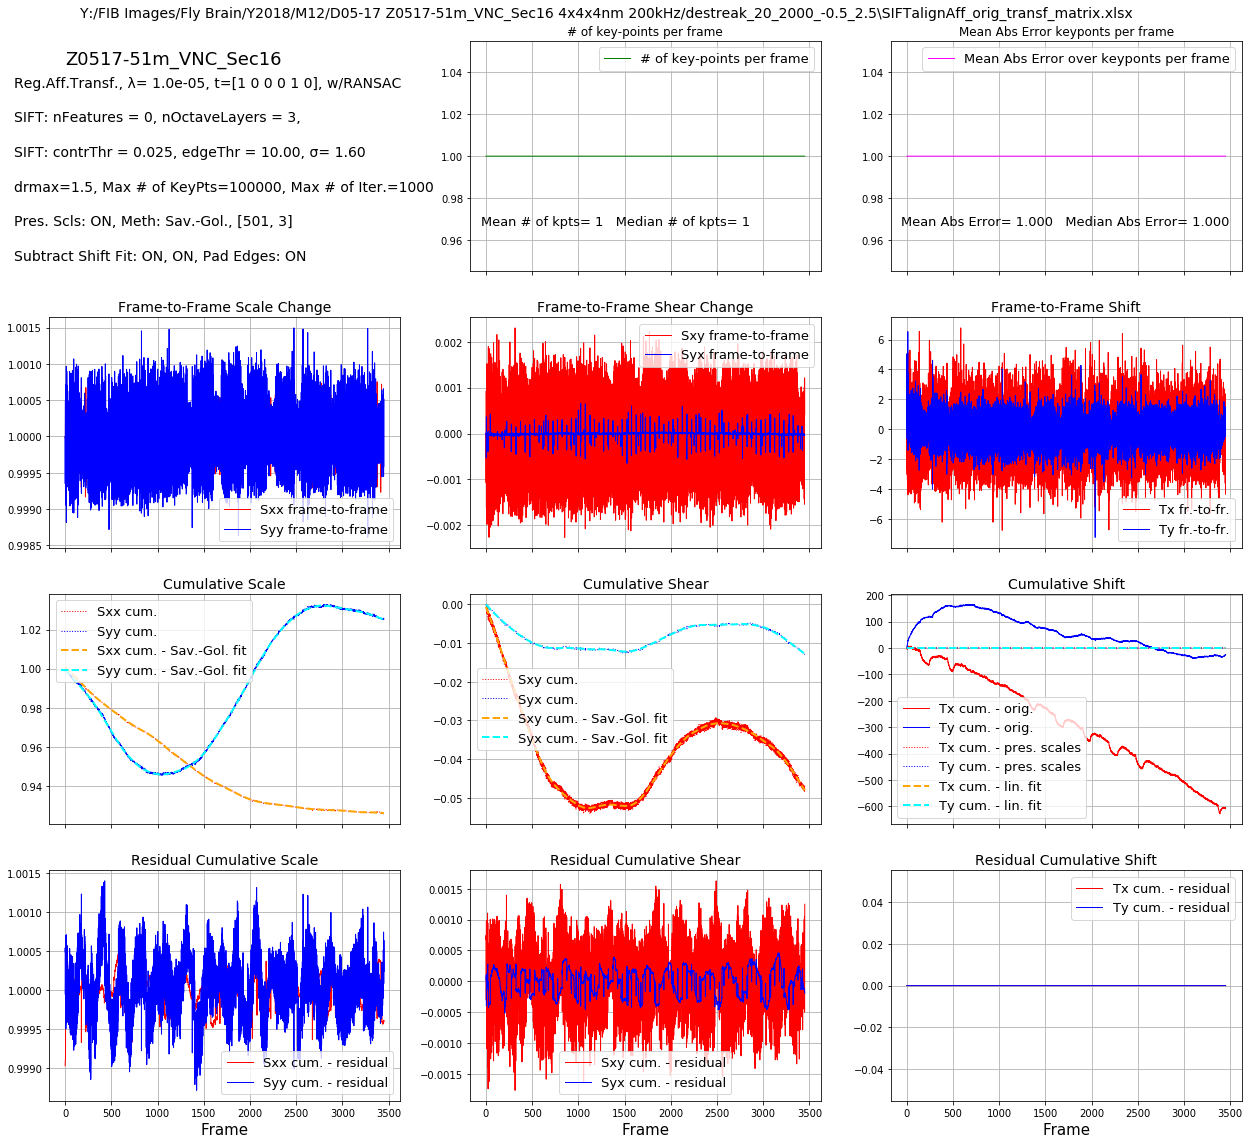

In [7]:
tr_matr_aff_residual, tr_matr_aff_xlsx_file = process_transf_matrix(transformation_matrix_aff,
                                             fnms_matches,
                                             npts,
                                             error_abs_mean,
                                             **SIFT_kwargs)

generate_report_transf_matrix_from_xlsx(tr_matr_aff_xlsx_file)

C:\tools\miniconda3\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Calculating Cummilative Transformation Matrix:   0%|          | 0/4379 [00:00<?, ?it/s]

Frame: 1401 has ill-defined transformation matrix, will use identity transformation instead:
[[ 1. -0. nan]
 [-0.  1. nan]
 [ 0.  0.  1.]]
Frame: 1402 has ill-defined transformation matrix, will use identity transformation instead:
[[ 1.    -0.     9.515]
 [-0.     1.       nan]
 [ 0.     0.     1.   ]]
Frame: 3652 has ill-defined transformation matrix, will use identity transformation instead:
[[ 1. -0. nan]
 [-0.  1. nan]
 [ 0.  0.  1.]]
Frame: 3721 has ill-defined transformation matrix, will use identity transformation instead:
[[ 1. -0. nan]
 [-0.  1. nan]
 [ 0.  0.  1.]]


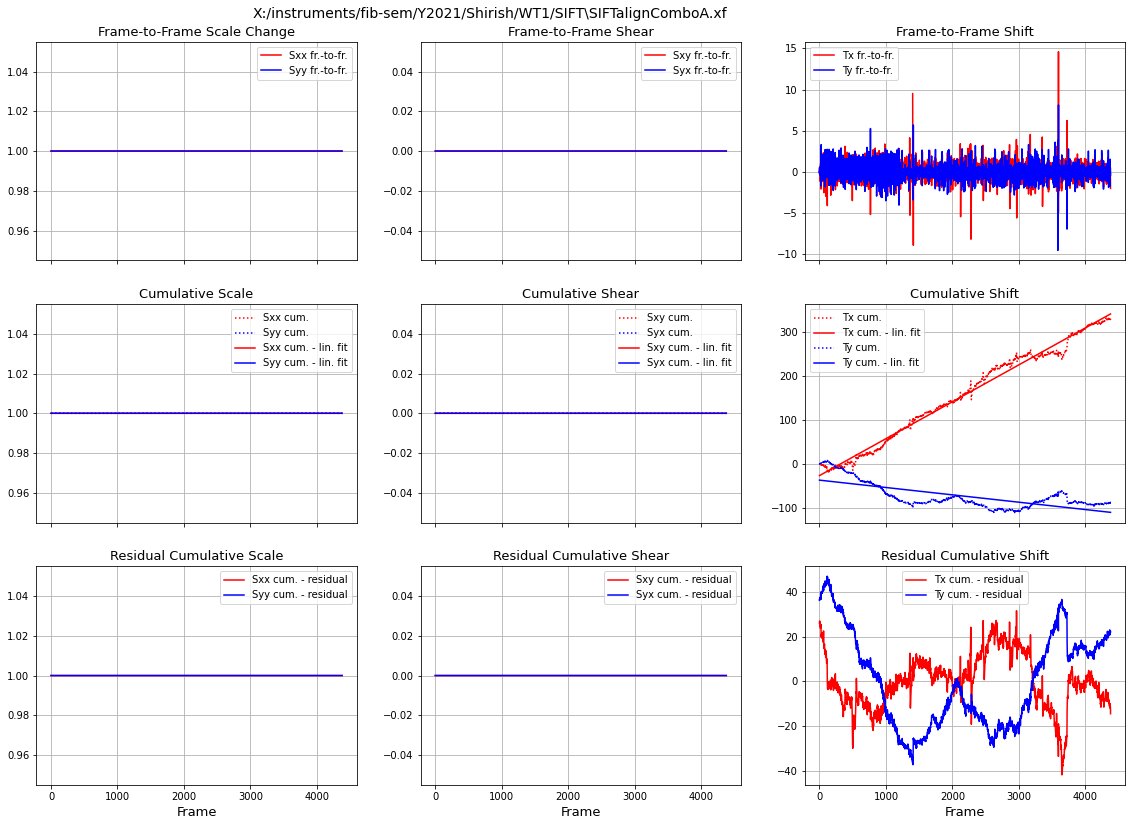

In [35]:
data_dir = 'X:/instruments/fib-sem/Y2021/Shirish/WT1/SIFT'
transf_file = 'SIFTalignComboA.xf'
fn = os.path.join(data_dir, transf_file)

transformation_matrix_aff = read_transformation_matrix_from_xf_file(fn)
tt = analyze_transformation_matrix(transformation_matrix_aff, fn)

In [48]:
lwl=1
fs=12
nmi = [np.mean(image_mi), np.median(image_mi), np.std(image_mi)]

Processing the data file  X:/instruments/fib-sem/Y2021/Shirish/WT1/mrc\rawstack-imgA.mrc


Evaluating frame registration:   0%|          | 0/4378 [00:00<?, ?it/s]

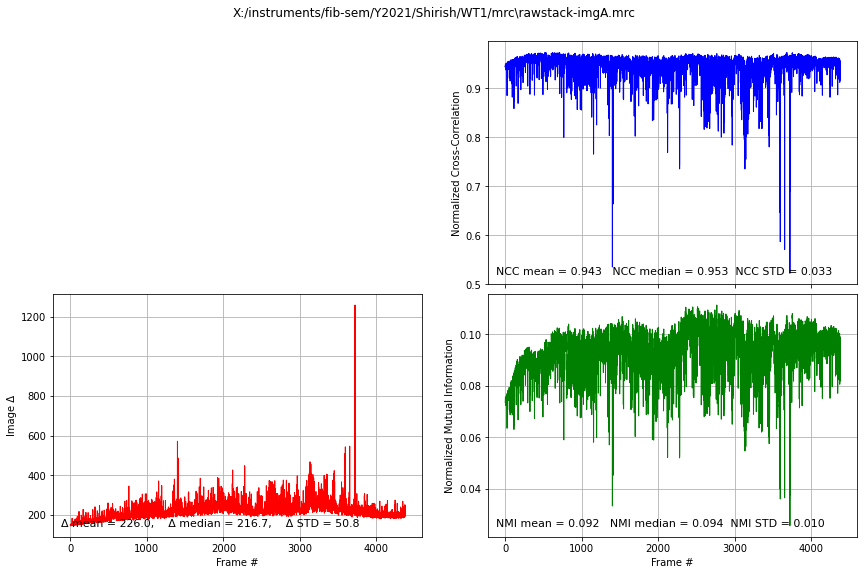

In [52]:
data_dir = 'X:/instruments/fib-sem/Y2021/Shirish/WT1/mrc'
files = ['SIFTalignCombo-imgA.mrc',
        'rawstack-imgA.mrc']

lwl=1
fs=12

for mrc_stack in files:
    fmrc = os.path.join(data_dir, mrc_stack)
    padx1 = 100
    pady1 = 100

    mrc = mrcfile.mmap(fmrc, mode='r+')
    header = mrc.header
    nx, ny, nz = int32(header['nx']), int32(header['ny']), int32(header['nz'])

    image_diff = np.zeros((nz-1), dtype=float)
    image_ncc = np.zeros((nz-1), dtype=float)
    image_mi = np.zeros((nz-1), dtype=float) 

    prev_frame = mrc.data[0, pady1:-pady1, padx1:-padx1].astype(float)
    frames = np.arange(nz-1)+1
    print('Processing the data file ', fmrc)
    for j in tqdm(frames, desc='Evaluating frame registration: '):
        curr_frame = mrc.data[j, pady1:-pady1, padx1:-padx1].astype(float)
        I1c = cp.array(curr_frame)
        I2c = cp.array(prev_frame)
        image_diff[j-1] =  cp.asnumpy(cp.mean(cp.abs(I1c-I2c)))
        image_ncc[j-1] = correlation_coefficient(prev_frame, curr_frame)
        image_mi[j-1] = cp.asnumpy(mutual_information_2d_cp(I1c.ravel(), I2c.ravel(), sigma=1.0, bin=2048, normalized=True))
        del I1c, I2c
        prev_frame = curr_frame.copy()
    mrc.close()

    imd = [np.mean(image_diff), np.median(image_diff), np.std(image_diff)] 
    nccs = [np.mean(image_ncc), np.median(image_ncc), np.std(image_ncc)]
    nmi = [np.mean(image_mi), np.median(image_mi), np.std(image_mi)]
    
    fig4, axs4 = subplots(2,2, figsize=(12, 8), sharex=True)
    fig4.subplots_adjust(left=0.06, bottom=0.06, right=0.99, top=0.92, wspace=0.18, hspace=0.04)

    #axs4[0,0].plot(error_abs_mean, 'magenta', linewidth=lwl)
    #axs4[0,0].text(0.02, 0.12, cond_str, transform=axs4[0,0].transAxes)
    #axs4[0,0].text(0.02, 0.04, 'Mean Abs Error= {:.3f}   Median Abs Error= {:.3f}'.format(np.mean(error_abs_mean), np.median(error_abs_mean)), transform=axs4[0,0].transAxes, fontsize = fs-1)
    #axs4[0,0].set_ylabel('Mean Abs. Error (KeyPts)')
    axs4[0,0].axis(False)

    axs4[1,0].plot(image_diff, 'r', linewidth=lwl)
    axs4[1,0].set_ylabel('Image Δ')
    #axs4[1,0].text(0.02, 0.12, cond_str, transform=axs4[0,1].transAxes)
    axs4[1,0].text(0.02, 0.04, 'Δ mean = {:.1f},    Δ median = {:.1f},    Δ STD = {:.1f}'.format(imd[0], imd[1], imd[2]), transform=axs4[1,0].transAxes, fontsize = fs-1)
    axs4[1,0].set_xlabel('Frame #')

    axs4[0,1].plot(image_ncc, 'b', linewidth=lwl)
    axs4[0,1].set_ylabel('Normalized Cross-Correlation')
    axs4[0,1].grid(True)
    #axs4[0,1].legend(loc='upper left')
    #axs4[0,1].text(0.02, 0.12, cond_str, transform=axs4[1,0].transAxes)
    axs4[0,1].text(0.02, 0.04, 'NCC mean = {:.3f}   NCC median = {:.3f}  NCC STD = {:.3f}'.format(nccs[0], nccs[1], nccs[2]), transform=axs4[0,1].transAxes, fontsize = fs-1)

    axs4[1,1].plot(image_mi, 'g', linewidth=lwl)
    axs4[1,1].set_ylabel('Normalized Mutual Information')
    axs4[1,1].set_xlabel('Frame #')
    axs4[1,1].grid(True)
    #axs4[1,1].legend(loc='upper left')
    #axs4[1,1].text(0.02, 0.12, cond_str, transform=axs4[1,1].transAxes)
    axs4[1,1].text(0.02, 0.04, 'NMI mean = {:.3f}   NMI median = {:.3f}  NMI STD = {:.3f}'.format(nmi[0], nmi[1], nmi[2]), transform=axs4[1,1].transAxes, fontsize = fs-1)

    for ax in axs4.ravel():
        ax.grid(True)
        #ax.legend(loc='upper left')

    ld = len(fmrc)
    ldm = 100
    fmrc_short = fmrc if ld<ldm else '... '+fmrc[-ldm:]     
    fig4.suptitle(fmrc_short, fontsize=fs)
    fig4.savefig(fmrc.replace('.mrc','_RegistrationQuality.png'), dpi=300)
    
    registration_summary_fnm = fmrc.replace('.mrc', '_RegistrationQuality.csv')
    columns=['Image Delta', 'Image NCC', 'Image MI']
    reg_summary = pd.DataFrame(np.vstack((image_diff, image_ncc, image_mi)).T, columns = columns, index = None)
    reg_summary.to_csv(registration_summary_fnm, index = None)